Downloading the dependices

In [1]:
!pip install -q -U git+https://github.com/lvwerra/trl.git
!pip install -q -U bitsandbytes
!pip install -U -q git+https://github.com/huggingface/transformers@de9255de27abfcae4a1f816b904915f0b1e23cd9
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U sentencepiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.

Downloading datasets

In [2]:
from datasets import load_dataset
dbricks_15k_dataset_base = load_dataset("databricks/databricks-dolly-15k")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
dbricks_15k_dataset_base

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15011
    })
})

plotting the sequence length of the data---->so that we can drop the larger examples

In [4]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj):
    sequence_lengths = []
    too_long = []# a list of too long sentences

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > 2200:
          too_long.append(idx)#to keep track of index of too long sentences

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

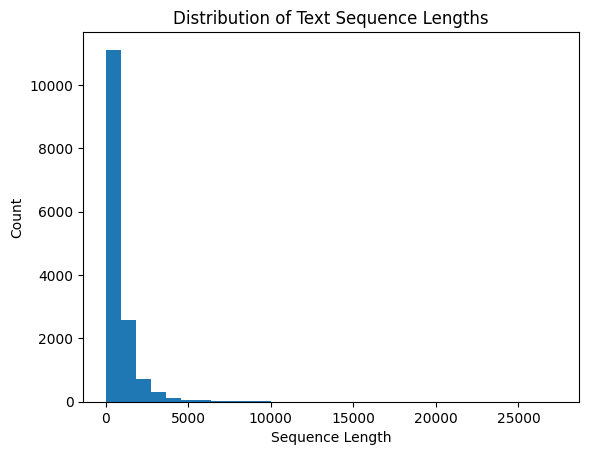

In [6]:
index_to_drop = plot_sequence_lengths(dbricks_15k_dataset_base)

In [7]:
len(index_to_drop)# have to drop these indexes

936

In [8]:
dbricks_reduced = dbricks_15k_dataset_base["train"].select(
    i for i in range(len(dbricks_15k_dataset_base["train"])) if i not in set(index_to_drop)
)

Parameter 'indices'=<generator object <genexpr> at 0x7bfe2be5aa40> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [11]:
dbricks_reduced #no train test split here

Dataset({
    features: ['instruction', 'context', 'response', 'category'],
    num_rows: 14075
})

Train test split on reduced dataset

In [12]:
dbricks_final = dbricks_reduced.train_test_split(test_size=0.1)

In [15]:
dbricks_final

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 1408
    })
})

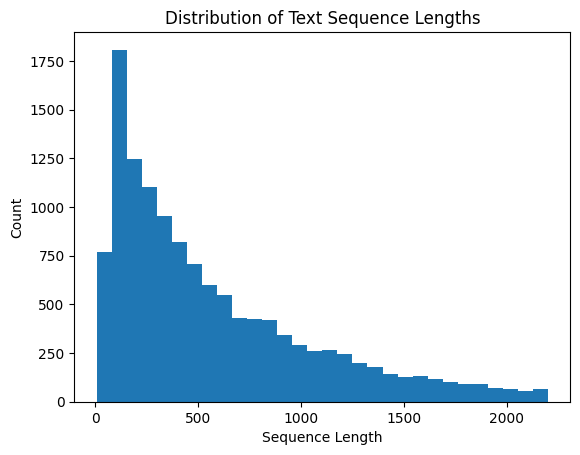

In [14]:
index_= plot_sequence_lengths(dbricks_final)

Formatting the training dataset ->like how it will be presented to the model while training

In [16]:
def format(example):
  if example.get("context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}

In [20]:
#below is the diff between the formatted and non formatted example
sample1=dbricks_final['train'][0]
print(sample1)
print('-------------------------------------')
format_sample1=format(sample1)
print(format_sample1)

{'instruction': 'what book would you recommend for pregnant women?', 'context': '', 'response': "Pregnant women have a lot on their plate, including their own physical and mental health and preparation for childbirth and newborn care. What to expect when you are expecting written by Heidi Murkoff is a popular book that provides a 360 degree view of pregnancy details like week-by-week fetal development and nutrient recommendations for each month. Expecting better by Emily Oster is another popular, more data-oriented and anecdotal, aiming to debunk common misguided rules and myths about pregnancy. Heng Ou's Nine Golden Months focuses more on mental power and nutrient suggestions for expecting moms. It also provides incredible recipes that turn easy-to-access grocery store staples to tasty and nutrient dishes.", 'category': 'open_qa'}
-------------------------------------
{'text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\

In [22]:
format_dataset = dbricks_final.map(format)

Map:   0%|          | 0/12667 [00:00<?, ? examples/s]

Map:   0%|          | 0/1408 [00:00<?, ? examples/s]

In [23]:
format_dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 12667
    })
    test: Dataset({
        features: ['instruction', 'context', 'response', 'category', 'text'],
        num_rows: 1408
    })
})

In [24]:
format_dataset['train'][0]

{'instruction': 'what book would you recommend for pregnant women?',
 'context': '',
 'response': "Pregnant women have a lot on their plate, including their own physical and mental health and preparation for childbirth and newborn care. What to expect when you are expecting written by Heidi Murkoff is a popular book that provides a 360 degree view of pregnancy details like week-by-week fetal development and nutrient recommendations for each month. Expecting better by Emily Oster is another popular, more data-oriented and anecdotal, aiming to debunk common misguided rules and myths about pregnancy. Heng Ou's Nine Golden Months focuses more on mental power and nutrient suggestions for expecting moms. It also provides incredible recipes that turn easy-to-access grocery store staples to tasty and nutrient dishes.",
 'category': 'open_qa',
 'text': "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nwhat book would 

downloading model
and setting up lora and tokenizer

In [26]:
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "openlm-research/open_llama_7b" #model name on hugging face

qlora_config = LoraConfig(
    #hyperparameters for finetuning using qlora -> based on original repo of this model and other repo using this
    r=16, #rank of matrix 100x100-> 100x16 and 16x100  16 is default value
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
#in order to add qunatisation to the model
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,#32bit to 4bit integers to keep value small so that it can be trained
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
from transformers import LlamaTokenizer
#downloading the tokenizer for lamma model
tokenizer = LlamaTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [29]:
print(base_model) #all are in 4 bit

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
